In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_manchester
from functionword_tagger import FunctionWordTagger

plt.rcParams['figure.figsize'] = 15, 6

In [4]:
unigrams, bigrams, trigrams = get_manchester("/home/paul/corpora/Manchester/**/*", 
                                            cached=True, 
                                            gram_sizes=[1, 2, 3])

In [ ]:
def morisita(a, b, drop_zeros=False, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    if drop_zeros:
        df = pd.DataFrame({'a': a, 'b': b}).dropna(how='any')
        a, b = df.a, df.b
    else:
        a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

def morisita_child_adult(df, drop_zeros=False):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult, drop_zeros=drop_zeros)

def morisita_adult_adult(df, corpus1, corpus2):
    adult1 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus1)].ngram.value_counts()
    adult2 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus2)].ngram.value_counts()
    return morisita(adult1, adult2)

def per_session_plot(title):
    plt.grid()
    plt.xticks(np.arange(1,35))
    plt.title(title)
    plt.legend()
    plt.xlabel('Session Number')
    plt.ylabel("Morisita's Overlap Index")
    plt.show()

plt.rcParams['figure.figsize'] = 15, 6
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    if plot:
        per_session_plot(title or name)

def plot_all_children_together(df, name):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend();
    per_session_plot('Morisita Overlap Index for all children')

In [14]:
def plot_child_adult_morisita(dataset, label):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_child_adult)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot(label)

In [29]:
ftagger = FunctionWordTagger()

def categorize_ngram(ngram):
    return '/'.join(ftagger.categorize(word) for word in ngram.split(' '))

unigrams['fcat'] = unigrams.ngram.apply(categorize_ngram)

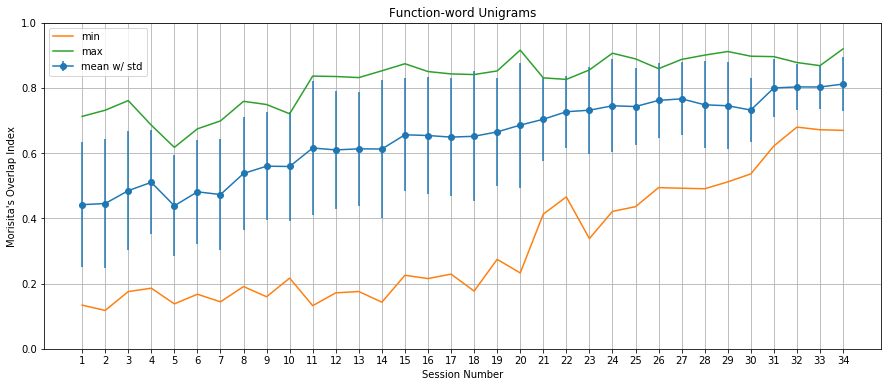

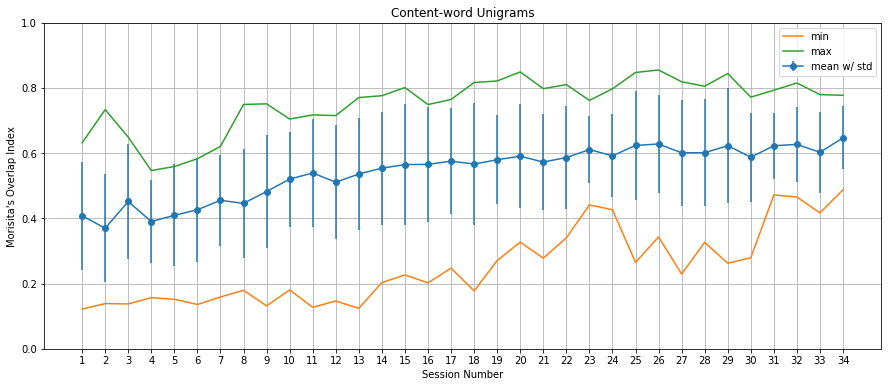

In [33]:
plot_child_adult_morisita(unigrams[unigrams.fcat.eq('F')], 'Function-word Unigrams')
plot_child_adult_morisita(unigrams[unigrams.fcat.eq('C')], 'Content-word Unigrams')

In [44]:
def comparative_plot(pairs):
    for df, label in pairs:
        groups = df.groupby(['corpus', 'session']).apply(morisita_child_adult)
        stats = groups.groupby(level='session').describe()
        plt.plot(stats.index, stats['mean'], label=label)

    plt.legend()
    plt.ylim(0, 1)

(0, 1)

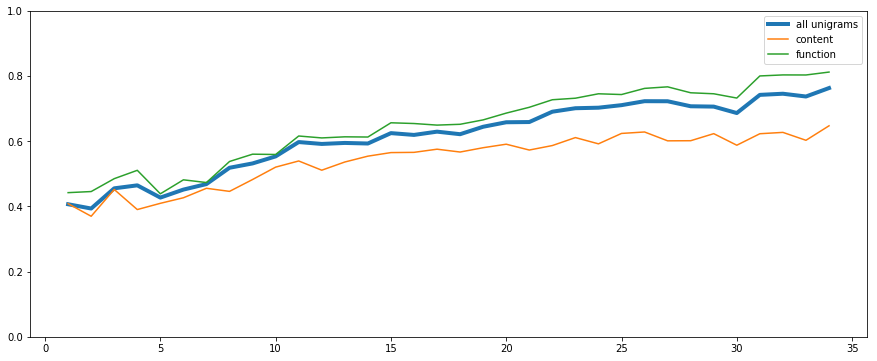

In [59]:
groups = unigrams
.groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='all unigrams', linewidth=4)

groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='content')

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='function')

plt.legend()
plt.ylim(0, 1)

In [42]:
bigrams['fcat'] = bigrams.ngram.apply(categorize_ngram)

(0, 1)

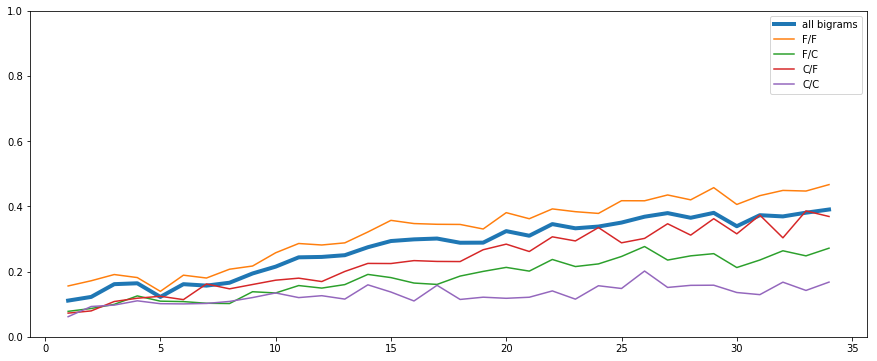

In [58]:
groups = bigrams.groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='all bigrams', linewidth=4)

for fcat in ['F/F', 'F/C', 'C/F', 'C/C']:
    groups = bigrams[bigrams.fcat.eq(fcat)].groupby(['corpus', 'session']).apply(morisita_child_adult)
    stats = groups.groupby(level='session').describe()
    plt.plot(stats.index, stats['mean'], label=fcat)
plt.legend()
plt.ylim(0, 1)

In [60]:
def shared_vocab(child_corpus, adult_corpus):
    "Computes the ngrams shared between the two speakers"
    return set(child_corpus.ngram.values) & set(adult_corpus.ngram.values)

def valid_ngram(ngram, shared_vocab): 
    "Returns true if the string `ngrams` only contains words from the shared vocab"
    for word in ngram.split(' '):
        if word not in shared_vocab:
            return False
    return True

# TODO: WTF is going on with nic 16 ??

def morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session):
    vocab_source = unigrams[unigrams.corpus.eq(corpus) & unigrams.session.lt(session + 1)]
    vocab = shared_vocab(vocab_source[vocab_source.speaker.eq('CHI')],
                         vocab_source[vocab_source.speaker.eq('MOT')])

    corpus_filter = dataset.corpus.eq(corpus)
    session_filter = dataset.session.eq(session)

    target_utts = dataset[corpus_filter & session_filter]
    child = target_utts[target_utts.speaker.eq('CHI')]
    adult = target_utts[target_utts.speaker.eq('MOT')]

    num_adult_utts = len(adult)
    adult = adult[adult.ngram.apply(lambda ngram: valid_ngram(ngram, vocab))]
    
    if adult.empty:
        return {'morisita': np.nan,
                'corpus': corpus,
                'session': session,
                'discarded_utts': num_adult_utts - len(adult)}
    
    moi = morisita(child.ngram.value_counts(), 
                   adult.ngram.value_counts())
    
    return {'morisita': moi,
            'corpus': corpus,
            'session': session,
            'child_utts': len(child),
            'adult_utts': num_adult_utts,
            'filtered_adult_utts': len(adult)}

In [78]:
# 

In [63]:
dataset=unigrams[unigrams.fcat.eq('C')]
shared_vocab_content_unigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

In [64]:
dataset=unigrams[unigrams.fcat.eq('F')]
shared_vocab_function_unigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

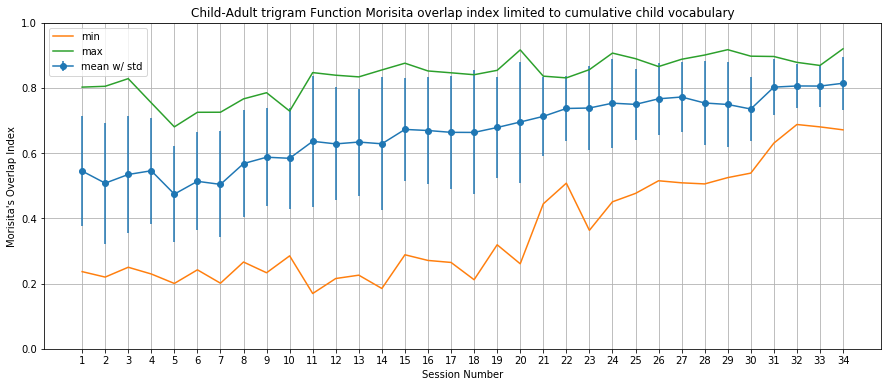

In [69]:
stats = shared_vocab_function_unigrams.groupby('session').morisita.describe()
plt.ylim(0, 1)
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats['min'])
plt.plot(stats['max'])
per_session_plot('Child-Adult {} Function Morisita overlap index limited to cumulative child vocabulary'.format(name))

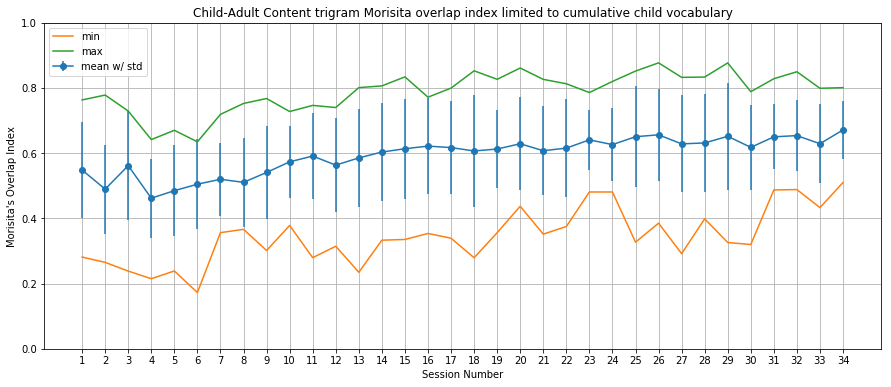

In [67]:
stats = shared_vocab_content_unigrams.groupby('session').morisita.describe()
plt.ylim(0, 1)
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats['min'])
plt.plot(stats['max'])
per_session_plot('Child-Adult Content {} Morisita overlap index limited to cumulative child vocabulary'.format(name))

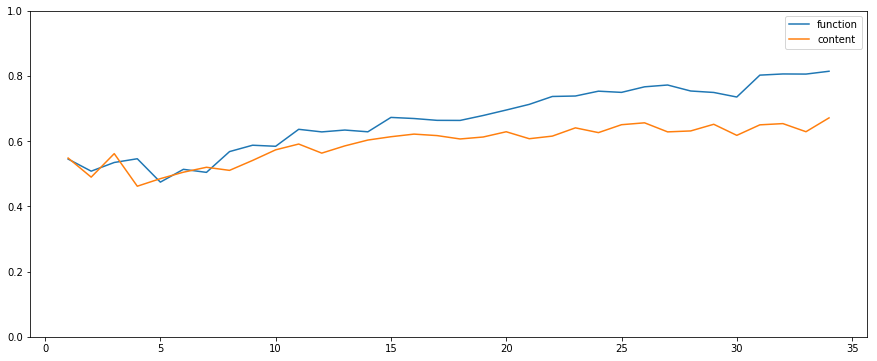

In [77]:
stats = shared_vocab_function_unigrams.groupby('session').morisita.describe()
plt.plot(stats['mean'], label='function')


stats = shared_vocab_content_unigrams.groupby('session').morisita.describe()
plt.plot(stats['mean'], label='content')

plt.legend()
plt.ylim(0, 1);

In [80]:
shared_vocab_bigrams = {}

for pair in ['F/F', 'F/C', 'C/F', 'C/C']:
    dataset=bigrams[bigrams.fcat.eq(pair)]
    shared_vocab_bigrams[pair] = pd.DataFrame([
        morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
        for corpus in dataset.corpus.unique()
        for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

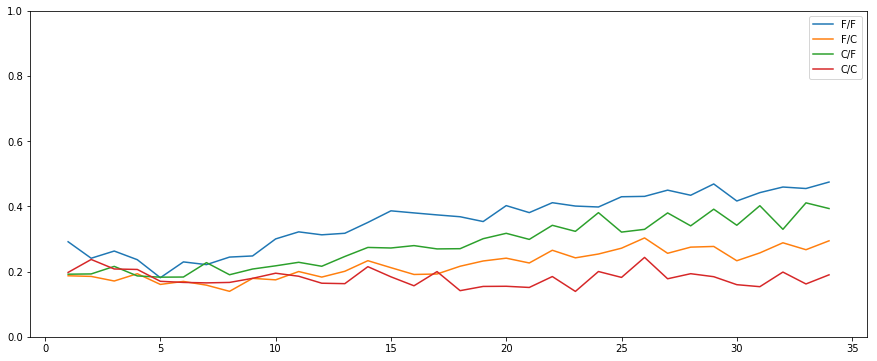

In [82]:
for group in ['F/F', 'F/C', 'C/F', 'C/C']:
    stats = shared_vocab_bigrams[group].groupby('session').morisita.describe()
    plt.plot(stats['mean'], label=group)
    
plt.legend()
plt.ylim(0, 1);